# Goal: Identify and Analyze Mobile Device Usage for 6.00.1x (...6.00.2x?)

1) Identify Mobile clicks

2) Isolate Mobile clicks

3) Agents, Events, and Event Types (for reference to clickstream data structure, see https://edx.readthedocs.io/projects/devdata/en/stable/internal_data_formats/tracking_logs.html)

Potential research questions:
    <br> - How often are mobile devices used with the 6.00.1x course?
    <br> - How do users interact with the 6.00.1x course on mobile devices?
    <br> - What patterns of behavior can we see in the mobile clickstream data?
    <br> - Hypothesis: Users on mobile click differently than non-mobile uers.

notes 
<br> nfs = network file system
<br> work with both courses
<br> interesting user? what makes someone an interesting user? frequent clicks? let's start with that.

In [17]:
!ls /yw_data/alfad8/newmitx 
! python --version

ls: cannot access '/yw_data/alfad8/newmitx': No such file or directory
Python 3.7.4


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from no_PII_Storage_folder import *

In [19]:
user_data_org = pd.read_json('data/clickstream/sample_mitx_6002x_7_1t2017_log_data.json',  lines = True)

In [20]:
user_data = user_data_org
user_data['username'] = hash_column(user_data_org['username'])
#user_data['mapped_username_on_alfa'] = hash_column(user_data_org['mapped_username_on_alfa'])

user_data.head(2)

# Save
#id_map.to_csv(os.path.join(SAVE_DATA_PATH, edit_name(ID_MAP_FILE_NAME)))

,time,username,ip,event_source,event_type,agent,course_id,host,context,mongoid,event_struct,event,name,session,module_id,page
0,2016-12-07 21:42:40.253149 UTC,5d482518821e6facc112c940cab04e15,18.189.12.11,server,edx.course.enrollment.activated,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,MITx/6.00.2x_7/1T2017,studio.edx.org,{'course_id': 'course-v1:MITx+6.00.2x_7+1T2017...,"{""event_struct"": {""state"": {}}, ""referer"": ""ht...",{'course_id': 'course-v1:MITx+6.00.2x_7+1T2017...,"{""course_id"": ""course-v1:MITx+6.00.2x_7+1T2017...",edx.course.enrollment.activated,5ac77cd1551f8a0b56b656395e712fd6,NaN,NaN
1,2016-12-07 21:44:28.023229 UTC,d41d8cd98f00b204e9800998ecf8427e,54.84.83.40,server,/api/commerce/v1/courses/course-v1:MITx+6.00.2...,python-requests/2.9.1,MITx/6.00.2x_7/1T2017,courses.edx.org,{'course_id': 'course-v1:MITx+6.00.2x_7+1T2017...,"{""event_struct"": {""state"": {}}, ""referer"": """",...","{'POST': '{}', 'GET': '{}'}","{""POST"": {}, ""GET"": {}}",NaN,NaN,NaN,NaN


In [21]:
#delete unecessary columns, 'page could be interesting to look @ later'
#will now look at 'name' instead of 'event_type' because "When this field is present for an event, it supersedes the event_type field"

user_data = user_data.drop(['context', 'course_id', 'host', 'event_struct', 'event_type', 'ip', 'page', 'mongoid', 'session','module_id', 'time'], axis = 'columns')

user_data.head(n=5)

,username,event_source,agent,event,name
0,5d482518821e6facc112c940cab04e15,server,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,"{""course_id"": ""course-v1:MITx+6.00.2x_7+1T2017...",edx.course.enrollment.activated
1,d41d8cd98f00b204e9800998ecf8427e,server,python-requests/2.9.1,"{""POST"": {}, ""GET"": {}}",NaN
2,86d70a75d701a090a36c9c3e07ed4b0f,browser,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52....,"""input_e046dd76e3be475d90eed4972d966612_2_1=de...",problem_save
3,6527b22f2839a8f2fc8c243b5c6442ca,browser,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,"""input_e046dd76e3be475d90eed4972d966612_2_1=%2...",problem_save
4,86d70a75d701a090a36c9c3e07ed4b0f,browser,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52....,"""input_e046dd76e3be475d90eed4972d966612_2_1=de...",problem_save


In [22]:
# #Searches for mobile users and adds them to new data frame with ONLY mobile users, takes LONG time
#For all keywords in user_data , this is incomplete

MOBILE_INDICATOR_1 = "mobi"
MOBILE_INDICATOR_2 = "Mobi"

mobile_data = pd.DataFrame()
non_mobile_data = pd.DataFrame()

mobile_data = user_data[user_data['agent'].str.contains(MOBILE_INDICATOR_1) | user_data['agent'].str.contains(MOBILE_INDICATOR_2)] 
non_mobile_data = user_data[~user_data['agent'].str.contains(MOBILE_INDICATOR_1) | ~user_data['agent'].str.contains(MOBILE_INDICATOR_2)] 

mobile_data = mobile_data.reset_index(drop=True)
non_mobile_data = non_mobile_data.reset_index(drop=True)
    
print("\nThere are " + str(len(mobile_data)) + " user-agents that contain: Mobi or mobi")
print("\nThere are " + str(len(non_mobile_data)) + " user-agents that DON'T contain:  Mobi or mobi")

# Mobi ref : https://delib.zendesk.com/hc/en-us/articles/203431259-Browser-device-identification-how-to-find-out-which-browser-and-device-have-been-used-to-submit-a-response


There are 8776 user-agents that contain: Mobi or mobi

There are 499629 user-agents that DON'T contain:  Mobi or mobi


In [23]:
mobile_data.head(n = 3)

,username,event_source,agent,event,name
0,1fc8371d6fb5d841af64503da54e4ec4,browser,Mozilla/5.0 (Linux; Android 7.1.1; A0001 Build...,"""input_cfae2cb6f0da4921a9420e11311c6762_2_1=co...",problem_check
1,aa75ce9861e361e2201c070fee4876ae,browser,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,"""input_809315f1470f4c95a176f37dd6dbbe82_2_1=n&...",problem_check
2,f7c9b5ba8e176a40998faa3874f04378,browser,Mozilla/5.0 (Linux; Android 5.0.2; HTC One Bui...,"""input_2dc927b6795c49b28c6fbf0d2f03f4f0_2_1=im...",problem_check


In [24]:
num_unique = user_data['event_source'].nunique(dropna = True)
unique_es = user_data['event_source'].unique()
print(num_unique)
print(unique_es)

3
['server' 'browser' 'mobile']


In [25]:
#check for mobile info in event source for comparison to user_agent info

mobile_data_es = pd.DataFrame()
        
mobile_data_es = mobile_data[mobile_data['event_source'].str.contains("mobi")] 
     
assert len(mobile_data_es) == 0
#print("\nThere are " + str(len(mobile_data_es)) + " event-sources that contain:  mobi")

In [26]:
#count different distinct events, then event types
#agent = mobile device/browser info, event =  includes member fields that identify specifics of each triggered event (?)
#name = event type, event_source = the source of the interaction that triggered the event

col_names = ['agent', 'event', 'name', 'event_source', 'username']
list_names = ['unique_agents', 'unique_events', 'unique_names', 'unique_event_sources', 'unique_usernames']
num_unique = []
all_uniques = []

def unique_counts(col_names, mobile_data):
    for count in range(len(col_names)):   
        list_names[count] = []
        list_names[count] = mobile_data[col_names[count]].unique()
        num_unique = mobile_data[col_names[count]].nunique(dropna = True)
        print("\nThere are " + str(num_unique) + " unique " + str(col_names[count]) + "s.")
        all_uniques.append(list_names[count])
    return (all_uniques)
        
all_uniques = unique_counts(col_names, mobile_data)

print("\n", all_uniques[2])
print("\n", all_uniques[3])


There are 163 unique agents.

There are 4154 unique events.

There are 26 unique names.

There are 2 unique event_sources.

There are 177 unique usernames.

 ['problem_check' 'problem_reset' 'problem_graded' 'page_close' nan
 'stop_video' 'pause_video' 'problem_show' 'hide_transcript'
 'show_transcript' 'edx.ui.lms.link_clicked' 'edx.ui.lms.outline.selected'
 'edx.grades.problem.submitted' 'edx.course.enrollment.activated'
 'edx.video.closed_captions.shown' 'edx.video.closed_captions.hidden'
 'edx.course.enrollment.deactivated' 'edx.ui.lms.sequence.next_selected'
 'edx.course.home.resume_course.clicked'
 'edx.ui.lms.sequence.previous_selected'
 'edx.course.student_notes.notes_page_viewed' 'load_video' 'play_video'
 'seek_video' 'edx.ui.lms.sequence.tab_selected' 'problem_save'
 'edx.forum.comment.created']

 ['browser' 'server']


In [27]:
len(user_data)

500000

# Check data with NaN elements removed

NONE of the the clicks that suggest a mobile device from 'user_agent' info are also listed as mobile in 'event_source info'

In [28]:
user_data_no_nan = user_data.dropna()
user_data_no_nan = user_data_no_nan.reset_index(drop=True)
print(len(user_data_no_nan))
user_data_no_nan.head(n = 2)

246502


,username,event_source,agent,event,name
0,5d482518821e6facc112c940cab04e15,server,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,"{""course_id"": ""course-v1:MITx+6.00.2x_7+1T2017...",edx.course.enrollment.activated
1,86d70a75d701a090a36c9c3e07ed4b0f,browser,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52....,"""input_e046dd76e3be475d90eed4972d966612_2_1=de...",problem_save


In [29]:
#Searches for mobile users and adds them to new data frame with ONLY mobile users (WITH NAN GONE)

mobile_data_no_nan = pd.DataFrame()

mobile_data_no_nan = user_data[user_data['agent'].str.contains(MOBILE_INDICATOR_1) | user_data['agent'].str.contains(MOBILE_INDICATOR_2)] 
mobile_data_no_nan = mobile_data_no_nan.reset_index(drop=True)
        
print("\nThere are " + str(len(mobile_data_no_nan)) + " user-agents that contain: Mobi or mobi")

mobile_data_no_nan.head(3)


There are 8776 user-agents that contain: Mobi or mobi


,username,event_source,agent,event,name
0,1fc8371d6fb5d841af64503da54e4ec4,browser,Mozilla/5.0 (Linux; Android 7.1.1; A0001 Build...,"""input_cfae2cb6f0da4921a9420e11311c6762_2_1=co...",problem_check
1,aa75ce9861e361e2201c070fee4876ae,browser,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,"""input_809315f1470f4c95a176f37dd6dbbe82_2_1=n&...",problem_check
2,f7c9b5ba8e176a40998faa3874f04378,browser,Mozilla/5.0 (Linux; Android 5.0.2; HTC One Bui...,"""input_2dc927b6795c49b28c6fbf0d2f03f4f0_2_1=im...",problem_check


In [31]:
col_names = ['agent', 'event', 'name', 'event_source']
list_names = ['unique_agents', 'unique_events', 'unique_names', 'unique_event_sources']
num_unique_no = []
all_uniques_no = []
        
all_uniques_no = unique_counts(col_names, mobile_data_no_nan)

print(all_uniques_no[2])


There are 163 unique agents.

There are 4154 unique events.

There are 26 unique names.

There are 2 unique event_sources.
['problem_check' 'problem_reset' 'problem_graded' 'page_close' nan
 'stop_video' 'pause_video' 'problem_show' 'hide_transcript'
 'show_transcript' 'edx.ui.lms.link_clicked' 'edx.ui.lms.outline.selected'
 'edx.grades.problem.submitted' 'edx.course.enrollment.activated'
 'edx.video.closed_captions.shown' 'edx.video.closed_captions.hidden'
 'edx.course.enrollment.deactivated' 'edx.ui.lms.sequence.next_selected'
 'edx.course.home.resume_course.clicked'
 'edx.ui.lms.sequence.previous_selected'
 'edx.course.student_notes.notes_page_viewed' 'load_video' 'play_video'
 'seek_video' 'edx.ui.lms.sequence.tab_selected' 'problem_save'
 'edx.forum.comment.created']


# Visualizing Data

plot to visualize modes, distributions, etc.
<br>-bar graphs of value counts for name, event (+ maybe agent, but that's messy so probably just display information)
<br>-same for non-mobile users^ (to look @ difference)
<br>-how can we look at behavior? aggregate OR groupby user
<br>-add error bars, pie charts could also visualize well

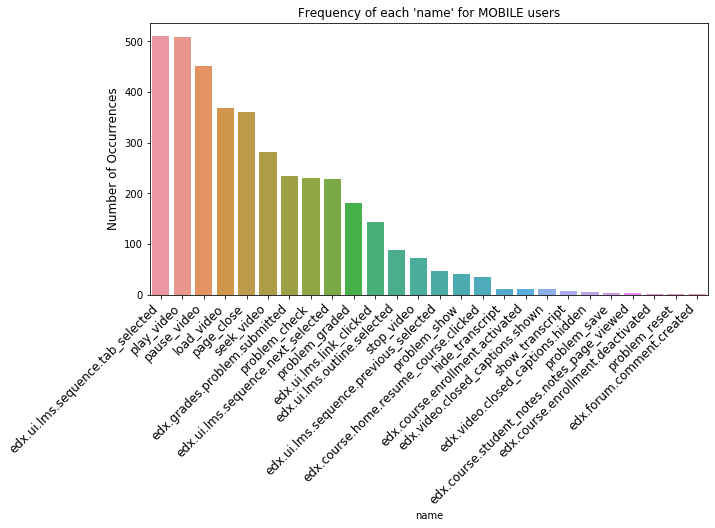

edx.ui.lms.sequence.tab_selected    511
play_video                          509
pause_video                         451
load_video                          368
page_close                          361
Name: name, dtype: int64

In [46]:
#function that plots frequencies of agent, event, name, and event_course 

name_count  = mobile_data['name'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(name_count.index, name_count.values, alpha=1)
plt.title("Frequency of each 'name' for MOBILE users")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('name', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

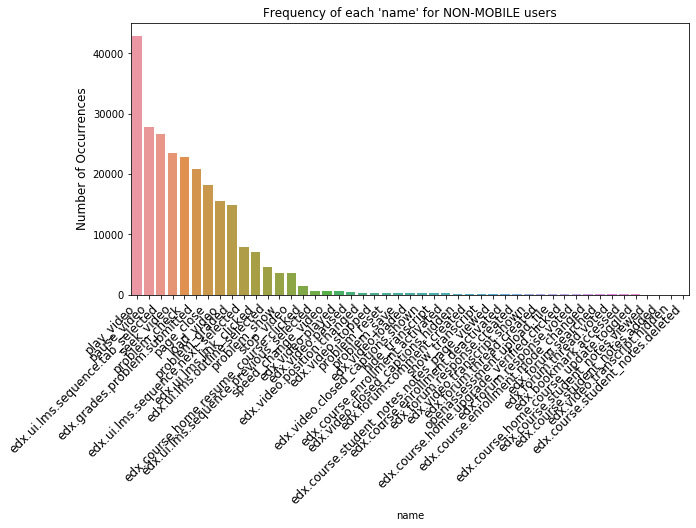

499629


In [33]:
non_name_count  = non_mobile_data['name'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(non_name_count.index, non_name_count.values, alpha=1)
plt.title("Frequency of each 'name' for NON-MOBILE users")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('name', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()
print(len(non_mobile_data))

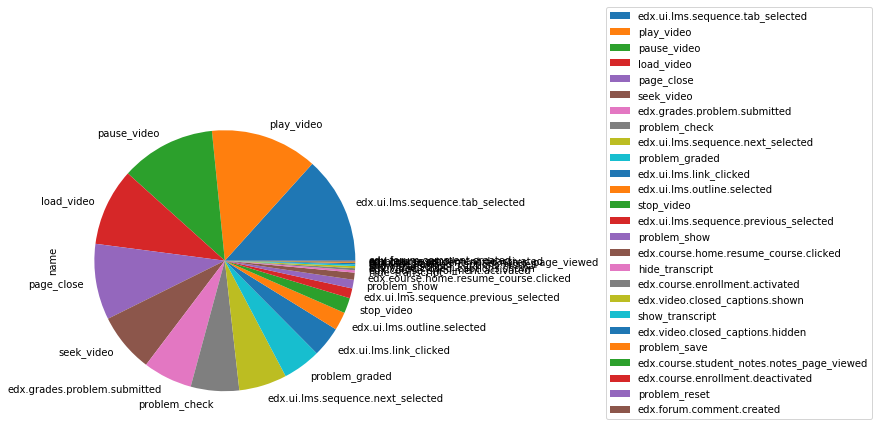

In [34]:
name_count.plot.pie(subplots=True, figsize=(6, 6))
plt.legend(bbox_to_anchor=(2.5,0), loc="lower right")
#type(name_count)
#name_count.head(5)

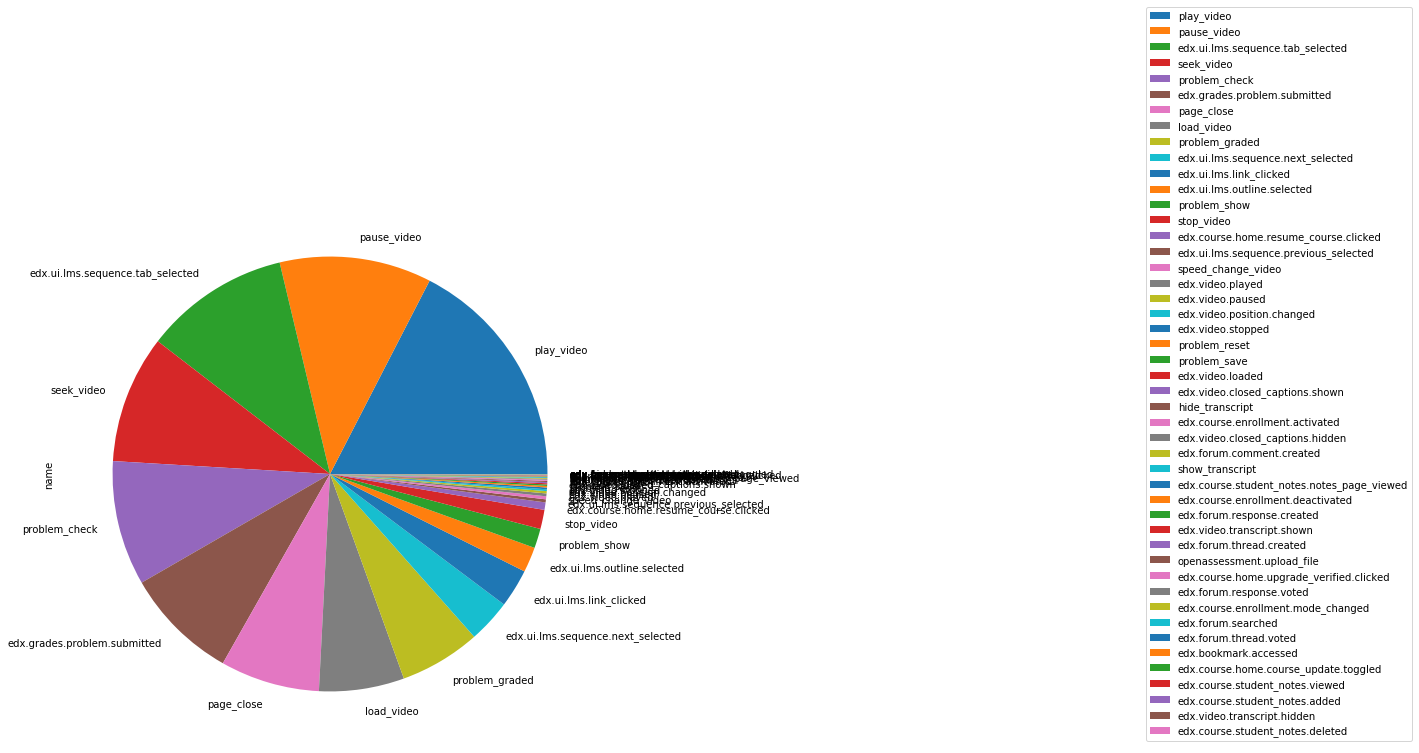

In [35]:
non_name_count.columns = ['values']
non_name_count.plot.pie(subplots=True, figsize=(10, 10))
plt.legend(bbox_to_anchor=(2.5,0), loc="lower right")

pause_video is most popular for mobile and non_mobile users (graphing takes a while to figure out, go for percentages to begin to quantify difference?) NOTES:
<br>page_close more popuar for mobile users (suggests minimal time spent on mobile course?)
<br>edx.grades.problem.submitted popular for both
<br> make better graphs, graph side by side, normalize, make above graph side-by-side

okay, so because of formatting updates, a lots of the names are actually the same...like pause_video is the same as edx.video.paused...sooooo I'm gonna fix that

In [36]:
#fix data frames
name_count = name_count.to_frame()
name_count = name_count.reset_index()
name_count.columns = ['name', 'values']

non_name_count = non_name_count.to_frame()
non_name_count = non_name_count.reset_index()
non_name_count.columns = ['name', 'values']

len(name_count)

26

In [37]:
#create list of all values that will serve as replacements (replacements will be older, original names because the 
#newer names are present with ONLY SOME OF THE MOBILE USERS)
replace_this = []
replace_with = []

replace_this = ['edx.video.transcript.hidden', 'edx.video.loaded', 'edx.video.paused', 'edx.video.played',
               'edx.video.position.changed', 'edx.video.transcript.shown', 'edx.video.stopped',
               'edx.video.language_menu.hidden', 'edx.video.language_menu.shown']
replace_with = ['hide_transcript', 'load_video', 'pause_video', 'play_video', 'seek_video', 'show_transcript',
               'stop_video', 'video_hide_cc_menu', 'video_show_cc_menu']

In [38]:
mobile =  []
non_mobile =  []
name_count_cpy = name_count
non_name_count_cpy = non_name_count

def replace_copies(raw_data):
    new_data = pd.DataFrame()
    for count in range(len(raw_data)):
        for num in range(len(replace_this)):
            if raw_data['name'][count] == replace_this[num]:
                #print("repeat")
                raw_data = raw_data.replace(to_replace = replace_this[num], 
                    value = replace_with[num]) 
    raw_data = raw_data.groupby(['name']).sum()
    raw_data = raw_data.reset_index()
    return raw_data

name_count_cpy = replace_copies(name_count)
non_name_count_cpy = replace_copies(non_name_count)
#non_name_count_cpy == non_name_count
            
def normalize_data(raw_data):
    x = raw_data[['values']].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return(x_scaled)

x_scaled = normalize_data(name_count)
y_scaled = normalize_data(non_name_count)

# Run the normalizer on the data
def apply_normalizer(normalized_data, device_type, device_list):
    normalized_df = pd.DataFrame(normalized_data)
    normalized_df.columns = ['normalized']
    for count in range(len(normalized_df)):
         device_list.append(device_type)
    normalized_df['device'] = device_list        
    return normalized_df

name_count_normalized = apply_normalizer(x_scaled, 'mobile', mobile)
non_name_count_normalized = apply_normalizer(y_scaled, 'non-mobile', non_mobile)
non_name_count_normalized.head(3)
    
result_1 = pd.concat([name_count, name_count_normalized], axis=1, sort=False)
result_2 = pd.concat([non_name_count, non_name_count_normalized], axis=1, sort=False)
result = pd.concat([result_1, result_2], axis = 0, sort = False)
result = result.reset_index(drop=True)

#remove very small occurences
for count in range(len(result)):
    if result['normalized'][count] < 0.009:
        result = result.drop(labels = [count], axis = 0)

result = result.reset_index(drop=True).sort_values(by = 'normalized', ascending = False)
result = result.reset_index(drop=True)

result.head(3)

,name,values,normalized,device
0,play_video,42952,1.000000,non-mobile
1,edx.ui.lms.sequence.tab_selected,511,1.000000,mobile
2,play_video,509,0.996078,mobile


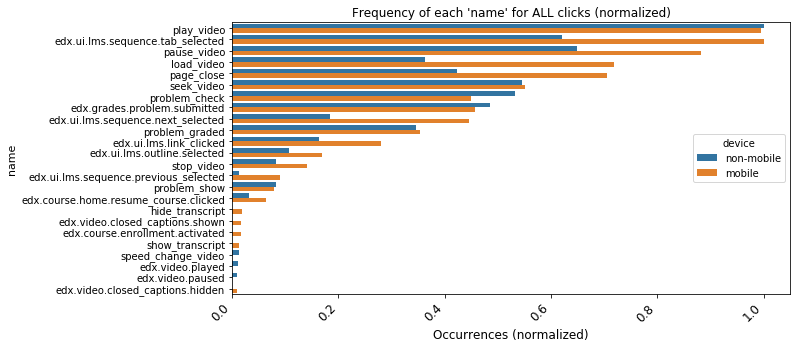

In [39]:
#make a horizontal bar plot with side by side data
plt.figure(figsize=(10,5))

sns.barplot(x = result['normalized'], y =  result['name'], hue = "device", data = result)
plt.title("Frequency of each 'name' for ALL clicks (normalized)")
plt.xlabel('Occurrences (normalized)', fontsize=12)
plt.ylabel('name', fontsize=11)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

In [40]:
#now, could look at event names as separated by usernames  
#make graph for each user? @ 500,000 data points, there is already 177 distinct mobile users...177 different graphs seems like a bit much

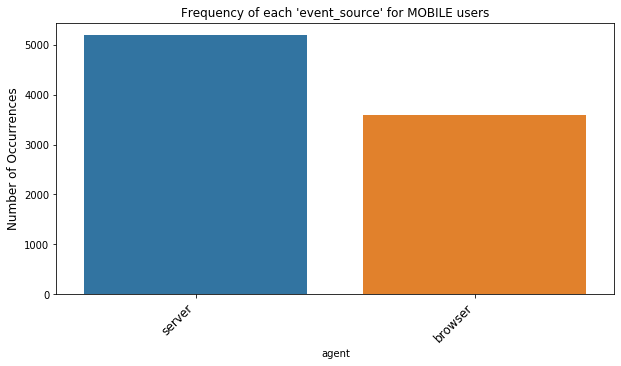

In [41]:
name_count  = mobile_data['event_source'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(name_count.index, name_count.values, alpha=1)
plt.title("Frequency of each 'event_source' for MOBILE users")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('agent', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

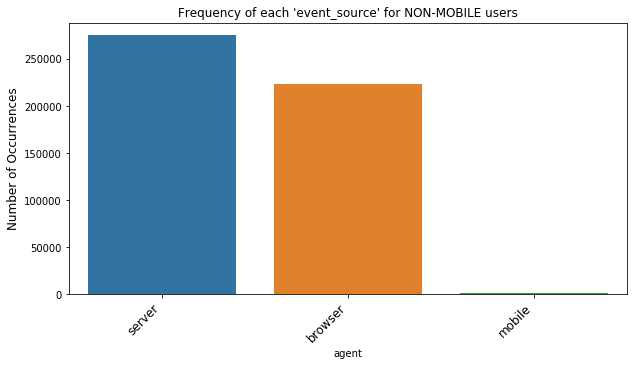

In [42]:
non_name_count  = non_mobile_data['event_source'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(non_name_count.index, non_name_count.values, alpha=1)
plt.title("Frequency of each 'event_source' for NON-MOBILE users")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('agent', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

# Find Interesting Users

take top 5 usernames, normalize and plot their frequencies to look @ individual behavior

In [111]:
#Find users with most total clicks. Alternatively, look at users with highest number of distinct clicks (wait...that doesn't make sense...nevermind)
NUM_TOP = 5
#no nan because lots of nans in names????
data_copy  = mobile_data.dropna()
data_copy = data_copy.reset_index(drop=True)

user_counts = pd.DataFrame()
user_counts  = data_copy['username'].value_counts()
user_counts = user_counts.reset_index()
user_counts.columns = ['username', 'no. clicks']

top_users = pd.DataFrame()
for count in range(NUM_TOP):
    top_users[count] = user_counts.loc[count]
top_users = top_users.T

top_users.head(NUM_TOP)

,username,no. clicks
0,9589599fce0cecbe02eb2b02457b1ef6,314
1,d39491d5e973c40e3b1e5957cce823ee,295
2,bb2d33a5636b647b21518bdb00c55cbf,153
3,4753bd3ceb797e82aabe1addef241d4e,143
4,6e1b401adef4664bbc5b17f8bbbb4c3f,132


In [112]:
#if mobile_data contains username, store in new data frame, graph by group
temp = pd.DataFrame
top_users_data = pd.DataFrame

top_users_data = data_copy[data_copy['username'].str.contains(top_users['username'][0])]

for count in range(1,5):
    temp = data_copy[data_copy['username'].str.contains(top_users['username'][count])]
    top_users_data = pd.concat([top_users_data, temp], axis = 0, sort = False)

top_users_data = top_users_data.reset_index(drop=True)
print(len(top_users_data))
top_users_data.head(5)

1037


,username,event_source,agent,event,name
0,9589599fce0cecbe02eb2b02457b1ef6,browser,Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS X...,"""input_63c84cff34bd4d888a73a4f4281faa5d_2_1%5B...",problem_check
1,9589599fce0cecbe02eb2b02457b1ef6,browser,Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS X...,"""input_63c84cff34bd4d888a73a4f4281faa5d_2_1%5B...",problem_check
2,9589599fce0cecbe02eb2b02457b1ef6,browser,Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS X...,"[""input_63c84cff34bd4d888a73a4f4281faa5d_2_1%5...",problem_graded
3,9589599fce0cecbe02eb2b02457b1ef6,browser,Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS X...,"[""input_63c84cff34bd4d888a73a4f4281faa5d_2_1%5...",problem_graded
4,9589599fce0cecbe02eb2b02457b1ef6,browser,Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS X...,{},page_close


In [113]:
top_users_data = top_users_data.dropna()
top_users_data = top_users_data.reset_index(drop=True)
print(len(top_users_data))
top_users_data.head(n = 2)

1037


,username,event_source,agent,event,name
0,9589599fce0cecbe02eb2b02457b1ef6,browser,Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS X...,"""input_63c84cff34bd4d888a73a4f4281faa5d_2_1%5B...",problem_check
1,9589599fce0cecbe02eb2b02457b1ef6,browser,Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS X...,"""input_63c84cff34bd4d888a73a4f4281faa5d_2_1%5B...",problem_check


In [133]:
top_users_grouped = pd.DataFrame
top_users_count = pd.DataFrame

top_users_grouped  = top_users_data.groupby(['username'])
top_users_count['values']  = top_users_grouped['name'].value_counts()
top_users_count = top_users_count.to_frame()

top_users_count = top_users_count.reset_index(level=1, drop=True)
top_users_count = top_users_count.reset_index()
#top_users_count.columns = top_users_count.columns.droplevel(0).reset_index()
#top_users_count.columns = ['username', 'name', 'values']
top_users_count.head(15)

TypeError: 'type' object does not support item assignment

In [95]:
#make a horizontal bar plot with side by side data
plt.figure(figsize=(10,5))

sns.barplot(x = top_users_count['values'], y =  top_users_count['name'], hue = "username", data = result)
plt.title("Frequency of each 'name' for ALL clicks (NOT normalized)")
plt.xlabel('Occurrences (normalized)', fontsize=12)
plt.ylabel('name', fontsize=11)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

KeyError: 'name'

<Figure size 720x360 with 0 Axes>